# TO do list

This is just a quick notebook to play around with. 

The most important things to do are:

<ul>
    <li> Check whether transitions structure induces any changes </li>
</ul>    
    
    
### Checks I have run. 

<ul>
    <li>Check poke_1 in event times against the lines in the text file </li>
    <li> Check that rsync timstamps are approx same as spike timestamps </li>
    <li> Check that rsync timestamps across two systems are spead across similar duration (and ephys ones are shorter) </li>
    <li> Check rsync timestamps against text file </li>
    
</ul>

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn
import networkx as nx
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d
import scipy.stats as stt
import scipy as sp
import re
sys.path.append("/Users/Yves/Documents/Code/structural_knowledge/packages/")
sys.path.append("/Users/Yves/Documents/Code/")

clrs = seaborn.color_palette()

seaborn.set(font_scale=1.5,style='ticks')
sys.path.append("/Users/yves/Downloads/code-master/tools/")

import rsync

import mouse_poker as mpk
from mouse_poker.ephys_load import *
import yutils

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [529]:
#Ok so the entire table is the following.I tihnk its probably easiest to just fit a linear model.

#Port poked   [X]
#Recent       [X]
#After error  
#After error2 
#task_nr      [X]
#correct_poke?
#probe_trial  
#previous_port_poked
#agnel_between_ports
#POKED IN TIMEOUT WINDOW!!!!

In [530]:
poke_pos = [  [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]]

In [531]:
#aa = np.array([int(re.findall(' ([0-9]*) ' ,i)[0]) for i in lines if '6\n' in i[-3:] and i.startswith('D')])
#bb = event_times[np.where(events=='poke_1')[0]]*1000


In [532]:
#all([i in aa for i in bb])

In [1129]:
f = open("/Users/yves/Documents/ephys_data/data/line_loop_ephys1/'456674_10'-2020-12-17-151542.txt","r")
#f = open("/Users/yves/Documents/ephys_data/data/line_loop_ephys1/'456674_10'-2020-12-15-134119.txt","r")
#f = open("/Volumes/hpc_dat/pycontrol/data/line_loop_ephys1/'459850_None'-2021-01-27-104446.txt",'r')

lines = f.readlines()
out = mpk.load.get_metadata(lines)

experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,summary_dict = out
dat_dict,events,event_times,nRews,event_dict = mpk.load.parse_data(lines,experiment_name)
date = (np.datetime64(date.replace(' ','T').replace('/','-'))).astype('object')


In [1130]:
rsync_times_pyc = np.array([t*1000*30 for i,t in enumerate(event_times) if events[i]=='rsync'])
print(len(rsync_times_pyc))
(rsync_times_pyc)[:5]

1022


array([141270., 239400., 381870., 616170., 683550.])

In [1131]:

rsync_times_pyc = np.array([int(re.findall(' ([0-9]*) ' ,i)[0]) for i in lines if '32\n' in i[-4:]])*30
print(len(rsync_times_pyc))

rsync_times_pyc[:5]

1024


array([     0, 141270, 239400, 381870, 616170])

In [1132]:
def load_base_dat(ROOT):
    
    paths = find_paths_ephys(ROOT)
    #print(paths)
    spkT_u, spkC, rsync_times_spk, clust_qual,start = load_paths(paths)
    return spkT_u, spkC, rsync_times_spk, clust_qual, start

In [1133]:
def find_paths_ephys(ROOT):
    done = False
    paths = []
    for a,b,c in os.walk(ROOT):
        #if a=='/Users/yves/Documents/ephys_data/2020_12_15/events/Rhythm_FPGA-107.0/TTL_1':
        #    print(c)
        for c_ in c:
            pth_ = os.path.join(a,c_)
            if ('spike_times' in pth_ or
                'spike_clusters' in pth_ or
                'timestamps.npy' in pth_ or
                'cluster_KSLabel' in pth_ or
                'sync_messages' in pth_):
                paths.append(pth_)
        ##print(a,b,c)
    return paths

In [1134]:
def load_paths(paths):
    start = None
    for pth in paths:
        if 'spike_times' in pth:
            spkT_u = np.load(pth)
        elif 'spike_clusters' in pth:
            spkC = np.load(pth)
        elif 'timestamps.npy' in pth:
            print(pth)
            rsync_times_spk = np.load(pth)
        elif 'KSLabel' in pth:
            clust_qual = pd.read_table(pth).KSLabel.values
        elif 'sync_messages' in pth:
            ls = open(pth,'r').readlines()
            for l_ in ls:
                if 'start time' in l_:
                    start = float(re.findall(r'start time: ([0-9]*)@30000Hz',l_)[0])
                    
    if start is None:
        print("WARNING! Did not find sync_messages.txt assuming start=0 ")
        start = 0
    return spkT_u, spkC, rsync_times_spk, clust_qual, start

In [999]:
ROOT = "/Volumes/hpc_dat/2021_01_27F/"

In [1135]:
ROOT = "/Users/yves/Documents/ephys_data/2020_12_17/"

In [1146]:
spkT_u, spkC, rsync_times_spk, clust_qual,offset = load_base_dat(ROOT)
print(offset)

/Users/yves/Documents/ephys_data/2020_12_17/events/Rhythm_FPGA-107.0/TTL_1/timestamps.npy
WARNING! Did not find sync_messages.txt assuming start=0 
0


In [1137]:
len(rsync_times_spk[::2])

1023

In [1138]:
len(rsync_times_pyc)

1024

In [1139]:
task_times = get_task_ranges(lines,task_nr,rsync_times_pyc)

In [1140]:
#spkT_u = np.load("/Users/yves/Documents/ephys_data/2020_12_15/kilosort/spike_times.npy")
#spkC = np.load("/Users/yves/Documents/ephys_data/2020_12_15/kilosort/spike_clusters.npy")
#rsync_times_spk = np.load("/Users/yves/Documents/ephys_data/2020_12_15/events/Rhythm_FPGA-107.0/TTL_1/timestamps.npy")
#clust_qual = pd.read_table("/Users/yves/Documents/ephys_data/2020_12_15/kilosort/cluster_KSLabel.tsv").KSLabel.values


In [1147]:
#offset = 1447800
#offset = 1448800
offset = 800400

spkT_u = spkT_u + offset

In [1148]:
unit_ids = np.where(clust_qual=='good')[0]
nUnits = len(unit_ids)

In [1149]:
#pd.read_table("/Users/yves/Documents/ephys_data/2020_12_15/kilosort/cluster_KSLabel.tsv")

In [1150]:
oa = rsync.Rsync_aligner(rsync_times_pyc,rsync_times_spk[::2],units_A=1,units_B=1)

In [1151]:
spkT = oa.B_to_A(spkT_u)
#spkT += offset

In [1152]:
unit_ids

array([ 24,  32,  33,  39,  44,  46,  49,  52,  55,  56,  57,  62,  66,
        72,  76,  83,  88,  89,  91,  97, 107, 108, 114, 122, 123, 128,
       140, 144, 145, 146, 149, 151, 152, 154, 155, 156, 158, 159, 160,
       161, 162, 163, 164, 165, 167, 168])

In [1153]:
bin_size = 10
spks = get_unit_spike_lists(spkT,spkC,unit_ids=unit_ids)
spk_arr = get_binned_spikes(spks,bin_size=bin_size)

In [1154]:
maxT = spk_arr.shape[1]


task1,task2 = get_port_to_state_map(dat_dict,task_times)
task_DM = build_task_DM(task_times,maxT,bin_size)
port_DM = build_port_DM(event_times,events,dat_dict,maxT,bin_size)
state_DMT1,state_DMT2 = build_state_DM(port_DM,task_DM,task1,task2)
lights_off_DM = get_lights_off_dm(events,event_times,maxT)

In [1155]:
pokeTs = np.where(port_DM.sum(axis=0))[0]


In [1156]:
ddT = [i[2] for i in dat_dict['port']]
pokeTs = np.where(port_DM.sum(axis=0))[0]
state_seq = [np.where(state_DMT1[:,pT])[0] for pT in pokeTs]

(0, 10)

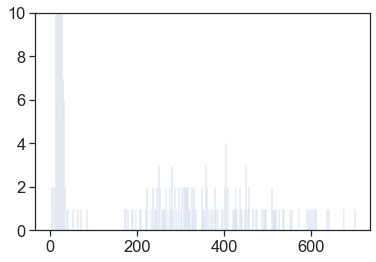

In [1157]:
seaborn.distplot([np.min(np.abs(i*1000-pokeTs*10)) for i in ddT],kde=0,bins=np.arange(0,700))
plt.ylim(0,10)

In [1158]:
def get_poke_detail_DM(dat_dict,port_DM,bin_size=10):
    
    """ 
        Ok first lets just assume this is correct and proceed. 
        All of this code needs CAREFUL checking!!!
    """
    probe_DM = np.zeros([1,port_DM.shape[1]])
    up_down_DM = np.zeros([2,port_DM.shape[1]])
    error_correct_DM = np.zeros([2,port_DM.shape[1]])
    pokeTs = np.where(port_DM.sum(axis=0))[0]

    for ctr,d in enumerate(dat_dict['port'][:-1]):
        if True:#d[-1]:
            pT_smaller = pokeTs*10#(pokeTs*10)[(pokeTs*10)<(d[2]*1000)]
            m1 = np.min(np.abs(pT_smaller-d[2]*1000))
            m2 = np.argmin(np.abs(pT_smaller-d[2]*1000))

            if True:#(d[2]*1000 - pT_smaller[m2])<50:

                #ll = len(pokeTs) - len((pokeTs*10)[(pokeTs*10)<(d[2]*1000)])

                t_conv = int(((pT_smaller[m2]/10)))
                probe_DM[0,t_conv] = 1

                going_down = (dat_dict['state'][ctr][0]>dat_dict['state'][ctr][1][0])

                if going_down:
                    up_down_DM[1,t_conv] = 1
                else:
                    up_down_DM[0,t_conv] = 1
                    
                #print(ctr,dat_dict['port'][ctr][0],np.where(port_DM[:,t_conv])[0][0])
                
                if ((dat_dict['port'][ctr][1]==dat_dict['port'][ctr+1][0]) and
                    (dat_dict['port'][ctr][0]==np.where(port_DM[:,t_conv])[0][0])):
                    error_correct_DM[1,t_conv] = 1
                else:
                    error_correct_DM[0,t_conv] = 1
                
                if d[-1]:
                    probe_DM[0,t_conv] = 1
            #print(ll)
            #print(d[2]*1000,
            #      pT_smaller[m2],
            #      (d[2]*1000)>(pT_smaller[m2]),
            #      d[2]*1000 - pT_smaller[m2],
            #     np.where(port_DM[:,t_conv])[0])
    return probe_DM, up_down_DM, error_correct_DM
            

In [1159]:
dat_dict['port'][:10]

[[0, 6, 21.051, False],
 [0, 6, 22.831, False],
 [6, 3, 23.807, False],
 [3, 2, 24.619, True],
 [2, 8, 27.169, False],
 [8, 2, 27.932, False],
 [2, 3, 28.316, False],
 [3, 6, 29.76, True],
 [6, 0, 32.01, False],
 [0, 1, 32.727, False]]

In [1160]:
probe_DM, up_down_DM, error_correct_DM = get_poke_detail_DM(dat_dict,port_DM)

In [1161]:
np.sum(error_correct_DM,axis=1)

array([348., 808.])

In [1162]:
pokeTs = np.where(port_DM.sum(axis=0))[0]
state_seq = [np.where(state_DMT1[:,pT])[0] for pT in pokeTs]

In [1163]:
def build_DM(dat_dict,spk_arr,task_times,events,event_times,bin_size=10):
    
    """ bin size is in ms
    """
    
    maxT = spk_arr.shape[1]
    

    task1,task2 = get_port_to_state_map(dat_dict,task_times)
    task_DM = build_task_DM(task_times,maxT,bin_size)
    port_DM, error_correct = build_port_DM(event_times,events,dat_dict,maxT,bin_size)
    state_DMT1,state_DMT2 = build_state_DM(port_DM,task_DM,task1,task2)
    lights_off_DM = get_lights_off_dm(events,event_times,maxT)


(0, 100000)

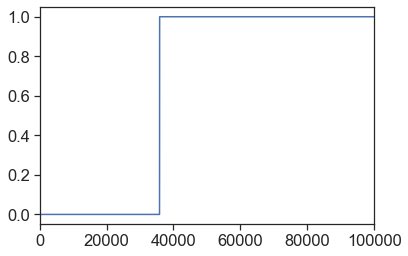

In [1164]:
plt.plot(task_DM[0])
plt.xlim(0,100000)

In [1165]:
store = []
for i in np.where(np.logical_and.reduce([error_correct_DM[1],task_DM[0]]))[0]:
        store.append(np.where(port_DM[:,i])[0])

In [1166]:
np.unique(store)

array([0, 3, 4, 5, 6, 7])

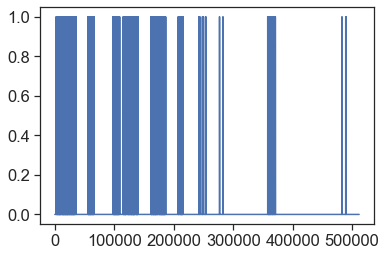

In [1167]:
plt.plot(error_correct_DM[1])

In [1168]:
np.unique(store)

array([0, 3, 4, 5, 6, 7])

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


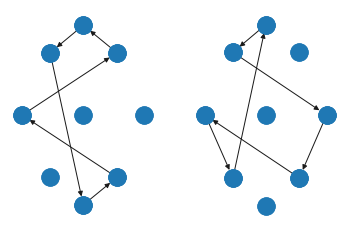

In [1169]:
for tNR in range(len(task_times)):
    plt.subplot(1,2,tNR+1)
    G0 = nx.DiGraph()

    G0.add_nodes_from(np.arange(9),pos=np.array([1,-1])*poke_pos)
    nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1)
    G = nx.DiGraph()
    G.add_edges_from([i for i in edges[tNR] if None not in i])
    nx.draw(G,
        pos=np.array([1,-1])*poke_pos,)
    nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1)

In [1170]:
def valid_corrcoef(a,b):
    ixs = np.logical_and(np.logical_not(np.isnan(a)),np.logical_not(np.isnan(b)))
    return np.corrcoef(a[ixs],b[ixs])[0,1]

In [1194]:
up_down_DM.shape

(2, 511768)

(2000, 5000)

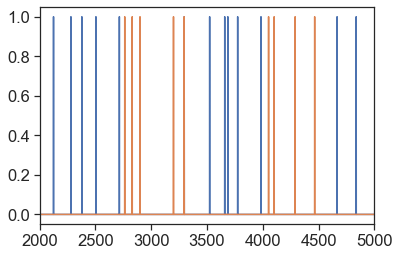

In [1201]:
plt.plot(up_down_DM[1,:10000])
plt.plot(up_down_DM[0,:10000])

plt.xlim(2000,5000)

In [1317]:
##COMPARE SAME TASK
astr = []
cstr = []

window = 8
task_nr = 0
for port in range(9):
    dat = np.array([np.nansum(spk_arr[:,ix_:ix_+window],axis=1) for ix_ in np.where(port_DM[port])[0] if 
                     (task_DM[task_nr,ix_] 
                      and not lights_off_DM[ix_]
                      #and ix_<100000
                      and error_correct_DM[1,ix_]
                      and up_down_DM[0,ix_]
                     )])
    
    mumu = np.nanmean(dat[::2],axis=0)
    mumu2 = np.nanmean(dat[1::2],axis=0)
    if type(mumu)==np.float64: mumu = np.zeros(spk_arr.shape[0]) + np.nan
    if type(mumu2)==np.float64: mumu2 = np.zeros(spk_arr.shape[0]) + np.nan

    astr.append(mumu)
    cstr.append(mumu2)
astr = np.array(astr).T
astr = astr *1000/(bin_size*window)

cstr = np.array(cstr).T
cstr = cstr *1000/(bin_size*window)

bstr = []
dstr = []

for port in range(9):
    dat = np.array([np.nansum(spk_arr[:,ix_:ix_+window],axis=1) for ix_ in np.where(port_DM[port])[0] if 
                     (task_DM[task_nr,ix_] 
                      and not lights_off_DM[ix_]
                      #and ix_>100000
                      and error_correct_DM[1,ix_]
                      and up_down_DM[1,ix_]
                     )])
                      
    mumu = np.nanmean(dat[::2],axis=0)
    mumu2 = np.nanmean(dat[1::2],axis=0)
    if type(mumu)==np.float64: mumu = np.zeros(spk_arr.shape[0]) + np.nan
    if type(mumu2)==np.float64: mumu2 = np.zeros(spk_arr.shape[0]) + np.nan

    bstr.append(mumu)
    dstr.append(mumu2)
bstr = np.array(bstr).T
bstr = bstr *1000/(bin_size*window)


dstr = np.array(dstr).T
dstr = dstr *1000/(bin_size*window)


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice


In [1282]:
dat.shape

(0,)

In [1272]:
##COMPARE DIFFERENT TASKS

window = 5

astr = []
for port in range(9):
    resps = [np.nansum(spk_arr[:,ix_:ix_+window],axis=1) for ix_ in np.where(port_DM[port])[0] if 
                     (task_DM[0,ix_] 
                      and not lights_off_DM[ix_]
                      and ix_<20000
                      and error_correct_DM[1,ix_]
                     )]
    print(len(resps))
    if len(resps)>=5:
        mumu = np.nanmean(np.array(resps),axis=0)
    else:
        mumu = np.nan
    if np.any(np.isnan(mumu)):
        mumu = np.zeros(spk_arr.shape[0]) + np.nan
    astr.append(mumu)
astr = np.array(astr).T
astr = astr *1000/(bin_size*window)

bstr = []
for port in range(9):
    resps = [np.nansum(spk_arr[:,ix_:ix_+window],axis=1) for ix_ in np.where(port_DM[port])[0] if 
                     (task_DM[1,ix_] 
                      and not lights_off_DM[ix_]
                      #and ix_<100000
                      and error_correct_DM[1,ix_]
                     )]
    if len(resps)>=5:
        mumu = np.nanmean(np.array(resps),axis=0)
    else:
        mumu = np.nan
    if np.any(np.isnan(mumu)):
        mumu = np.zeros(spk_arr.shape[0]) + np.nan

    bstr.append(mumu)
bstr = np.array(bstr).T
bstr = bstr *1000/(bin_size*window)


cstr = []
for port in range(9):
    resps = [np.nansum(spk_arr[:,ix_:ix_+window],axis=1) for ix_ in np.where(port_DM[port])[0] if 
                     (task_DM[0,ix_] 
                      and not lights_off_DM[ix_]
                      and ix_>20000
                      and error_correct_DM[1,ix_]
                     )]
    if len(resps)>=5:
        mumu = np.nanmean(np.array(resps),axis=0)
    else:
        mumu = np.nan
    if np.any(np.isnan(mumu)):
        mumu = np.zeros(spk_arr.shape[0]) + np.nan

    cstr.append(mumu)
cstr = np.array(cstr).T
cstr = cstr *1000/(bin_size*window)


0
0
0
0
0
0
0
0
0


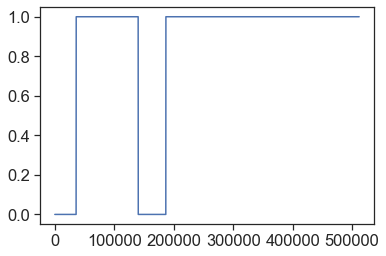

In [1217]:
plt.plot(task_DM[0])

In [1218]:
def get_task_edges(task_times,dat_dict):
    """ Get edges in each of the tasks """
    
    edges = []
    for task_nr in range(2):
        tmp = []
        for ctr,i in enumerate(dat_dict['port']):

            if np.any([np.logical_and((i[2]*1000)>t_[0],(i[2]*1000)<t_[1]) for t_ in task_times[task_nr]]):

                if [i[0],i[1]] not in edges: tmp.append([i[0],i[1]])
        edges.append(tmp)
    return edges

In [1219]:
edges = get_task_edges(task_times,dat_dict)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


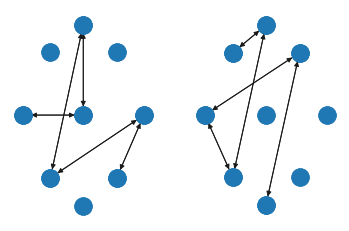

In [1220]:
for tNR in range(len(task_times)):
    plt.subplot(1,2,tNR+1)
    G0 = nx.DiGraph()

    G0.add_nodes_from(np.arange(9),pos=np.array([1,-1])*poke_pos)
    nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1)
    G = nx.DiGraph()
    G.add_edges_from([i for i in edges[tNR] if None not in i])
    nx.draw(G,
        pos=np.array([1,-1])*poke_pos,)
    nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1)

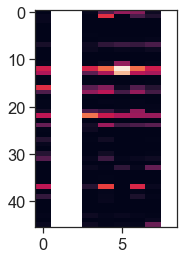

In [1221]:
plt.imshow(cstr,aspect=.3)

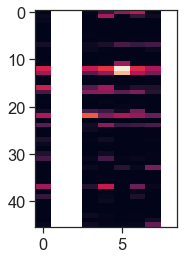

In [1230]:
plt.imshow(astr,aspect=.3)

0.6282173318484638


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


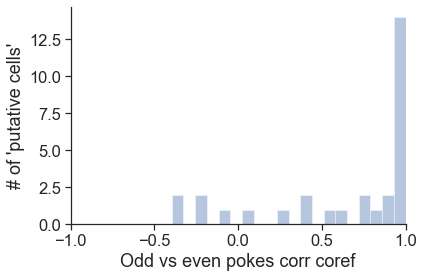

In [1231]:
acc = [valid_corrcoef(i,j) for i,j in zip(astr,bstr) if np.nanmax(np.concatenate([astr,bstr]))>4]
print(np.nanmean(acc))
seaborn.distplot(acc,kde=0,bins=20)
plt.xlim(-1,1)
plt.xlabel("Odd vs even pokes corr coref")
plt.ylabel("# of 'putative cells'")
seaborn.despine()

0.6282173318484638


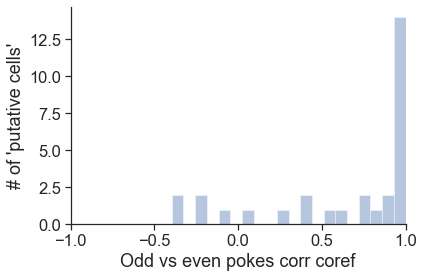

In [1232]:
acc = [valid_corrcoef(i,j) for i,j in zip(astr,bstr) if np.nanmax(np.concatenate([astr,bstr]))>2]
print(np.nanmean(acc))
seaborn.distplot(acc,kde=0,bins=20)
plt.xlim(-1,1)
plt.xlabel("Odd vs even pokes corr coref")
plt.ylabel("# of 'putative cells'")
seaborn.despine()

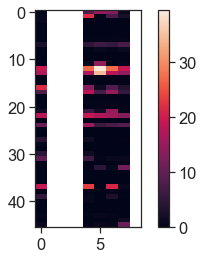

In [1233]:

plt.imshow(np.mean(np.dstack([astr,bstr]),axis=2),aspect=.4)
plt.colorbar()

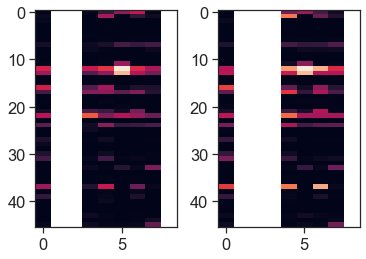

In [1234]:
plt.subplot(1,2,1)
plt.imshow(astr,aspect=.3)
plt.subplot(1,2,2)
plt.imshow(bstr,aspect=.3)

In [1235]:
#plt.plot(gaussian_filter1d(spk_arr[11],1000))
#plt.plot(task_DM[0]*.1)
#plt.xlim(0,100000)
#plt.ylim(0,.1)
len(cstr)

46

In [1117]:
valid_corrcoef(a_,c_)

0.9579737106577264

5.0 17 3.684210526315789 5.0


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


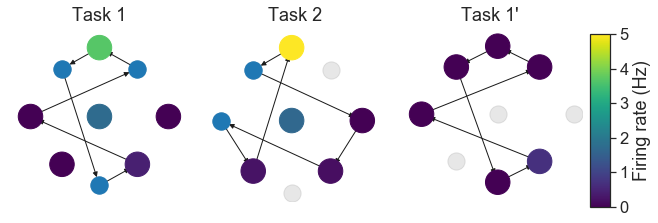

In [1176]:
plt.figure(figsize=(11,3))

ix = 30  #21 is good
c_ = cstr[ix]
a_,b_ = astr[ix], bstr[ix]
node_size = 600
plt.subplot(1,4,1)
plt.title("Task 1")

mx = np.nanmax(np.concatenate([a_,b_]))
print(mx,ctr,np.nanmax(a_),np.nanmax(b_))

G0 = nx.DiGraph()

G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos)
nx.draw_networkx_nodes(G0,pos=np.array([1,-1])*poke_pos,alpha=.1,node_color='k',linewidths=1)
G = nx.DiGraph()
G.add_edges_from([i for i in edges[0] if None not in i])
nx.draw(G,
    pos=np.array([1,-1])*poke_pos,)
nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,
        node_color=a_,vmin=0,vmax=mx
        ,cmap='viridis',node_size=node_size)


plt.subplot(1,4,2)
plt.title("Task 2")
G0 = nx.DiGraph()
G0.add_nodes_from(np.arange(9),pos=np.array([1,-1])*poke_pos)
nx.draw_networkx_nodes(G0,pos=np.array([1,-1])*poke_pos,alpha=.1,node_color='k',linewidths=1)

G = nx.DiGraph()
G.add_edges_from([i for i in edges[1] if None not in i])
nx.draw(G,
    pos=np.array([1,-1])*poke_pos,)
nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,
        node_color=b_,vmin=0,vmax=mx
        ,cmap='viridis',node_size=node_size)


plt.subplot(1,4,3)
plt.title("Task 1'")
G0 = nx.DiGraph()
G0.add_nodes_from(np.arange(9),pos=np.array([1,-1])*poke_pos)
nx.draw_networkx_nodes(G0,pos=np.array([1,-1])*poke_pos,alpha=.1,node_color='k',linewidths=1)

G = nx.DiGraph()
G.add_edges_from([i for i in edges[0] if None not in i])
nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,
        node_color=c_,vmin=0,vmax=mx
        ,cmap='viridis',node_size=node_size)
nx.draw_networkx_edges(G,pos=np.array([1,-1])*poke_pos)
#nx.draw(G,
#    pos=np.array([1,-1])*poke_pos,node_alpha=0)



plt.subplot(1,4,4)
plt.imshow(np.array([[0,mx]]).T,aspect=1001,cmap='viridis')
plt.gca().set_visible(False)
cax = plt.axes([.75, 0.025, 0.025, 0.8])
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Firing rate (Hz)")




#cax = pl.axes([0.1, 0.2, 0.8, 0.6])

ctr += 1
plt.tight_layout()
#plt.savefig("/Users/yves/Desktop/NOREMAP_cell_n.png",dpi=300)
#plt.savefig("/Users/yves/Desktop/NOREMAP_cell_n.svg")


In [1241]:
edg2 = []
for i in edges[0]:
    if None not in i:
        if i not in edg2:
            edg2.append(i)

In [1245]:
edg2[:4]

[[4, 0], [0, 6], [6, 5], [5, 7]]

In [1243]:
sorted(edg2)

[[0, 4],
 [0, 6],
 [3, 4],
 [4, 0],
 [4, 3],
 [5, 6],
 [5, 7],
 [6, 0],
 [6, 5],
 [7, 5]]

15.476190476190476 92 11.904761904761903 15.476190476190476


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


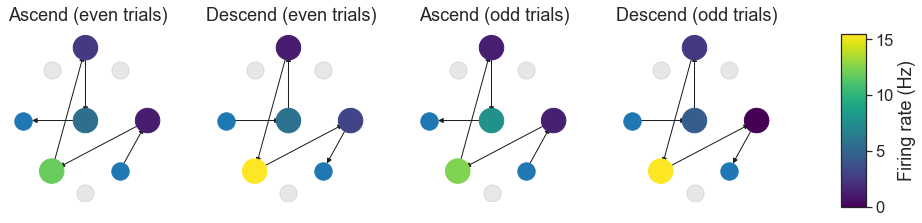

In [1324]:
plt.figure(figsize=(14,3))
astr[:,7] = np.nan
bstr[:,7] = np.nan
bstr[:,3] = np.nan
astr[:,3] = np.nan


cstr[:,7] = np.nan
dstr[:,7] = np.nan
dstr[:,3] = np.nan
cstr[:,3] = np.nan

ix = 21  #21 is good
c_ = cstr[ix]
a_,b_ = astr[ix], bstr[ix]
d_ = dstr[ix]
#bstr[:,-1] = np.nan
#astr[:,0] = np.nan
node_size = 600
plt.subplot(1,5,1)
plt.title("Ascend (even trials)")

mx = np.nanmax(np.concatenate([a_,b_]))
print(mx,ctr,np.nanmax(a_),np.nanmax(b_))

G0 = nx.DiGraph()

G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos)
nx.draw_networkx_nodes(G0,pos=np.array([1,-1])*poke_pos,alpha=.1,node_color='k',linewidths=1)
G = nx.DiGraph()
G.add_edges_from(np.array([[8,6],[6,7],[7,1],[1,5],[5,4]])-1)
nx.draw(G,
    pos=np.array([1,-1])*poke_pos,)
nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,
        node_color=a_,vmin=0,vmax=mx
        ,cmap='viridis',node_size=node_size)


plt.subplot(1,5,2)
plt.title("Descend (even trials)")
G0 = nx.DiGraph()
G0.add_nodes_from(np.arange(9),pos=np.array([1,-1])*poke_pos)
nx.draw_networkx_nodes(G0,pos=np.array([1,-1])*poke_pos,alpha=.1,node_color='k',linewidths=1)

G = nx.DiGraph()
G.add_edges_from(np.fliplr(np.array([[8,6],[6,7],[7,1],[1,5],[5,4]])-1))
nx.draw(G,
    pos=np.array([1,-1])*poke_pos,)
nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,
        node_color=b_,vmin=0,vmax=mx
        ,cmap='viridis',node_size=node_size)


plt.subplot(1,5,3)
plt.title("Ascend (odd trials)")
G0 = nx.DiGraph()
G0.add_nodes_from(np.arange(9),pos=np.array([1,-1])*poke_pos)
nx.draw_networkx_nodes(G0,pos=np.array([1,-1])*poke_pos,alpha=.1,node_color='k',linewidths=1)

G = nx.DiGraph()
G.add_edges_from(np.array([[8,6],[6,7],[7,1],[1,5],[5,4]])-1)
nx.draw(G,
    pos=np.array([1,-1])*poke_pos,)
nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,
        node_color=c_,vmin=0,vmax=mx
        ,cmap='viridis',node_size=node_size)


plt.subplot(1,5,4)
plt.title("Descend (odd trials)")
G0 = nx.DiGraph()
G0.add_nodes_from(np.arange(9),pos=np.array([1,-1])*poke_pos)
nx.draw_networkx_nodes(G0,pos=np.array([1,-1])*poke_pos,alpha=.1,node_color='k',linewidths=1)

G = nx.DiGraph()
G.add_edges_from(np.fliplr(np.array([[8,6],[6,7],[7,1],[1,5],[5,4]])-1))
nx.draw(G,
    pos=np.array([1,-1])*poke_pos,)
nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,
        node_color=d_,vmin=0,vmax=mx
        ,cmap='viridis',node_size=node_size)

plt.subplot(1,5,5)
plt.imshow(np.array([[0,mx]]).T,aspect=1001,cmap='viridis')
plt.gca().set_visible(False)
cax = plt.axes([.85, 0.025, 0.025, 0.8])
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Firing rate (Hz)")




#cax = pl.axes([0.1, 0.2, 0.8, 0.6])

ctr += 1
plt.tight_layout()
#plt.savefig("/Users/yves/Desktop/split_3.png",dpi=300)
#plt.savefig("/Users/yves/Desktop/split_3.svg")


In [1325]:
astr.shape

(46, 9)

In [1261]:
astr[:,7] = np.nan

array([ 0.43478261,  1.73913043,  0.        ,  0.        ,  0.        ,
        0.        ,  0.43478261,  7.39130435,  1.30434783,  0.        ,
        0.        ,  0.43478261, 18.26086957, 12.60869565,  0.        ,
        0.43478261,  3.47826087,  4.34782609,  0.        ,  0.        ,
        0.        ,  0.        , 11.30434783,  0.        ,  8.26086957,
        0.        ,  0.        ,  0.43478261,  0.        ,  0.        ,
        0.43478261,  0.43478261,  0.        , 13.04347826,  0.        ,
        0.        ,  0.        ,  0.86956522,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  2.17391304,
       10.86956522])

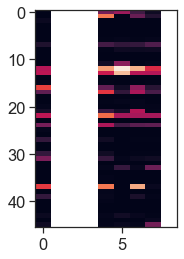

In [1208]:
plt.imshow(bstr,aspect=.3)

In [1209]:
bstr[:,-1]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan])

In [807]:
len(cstr)

46

In [795]:
len(bstr)

46

In [1191]:
bstr[:,0]

array([ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  3. ,  0. ,  0. ,  0. ,
        0. , 16.5, 17. ,  0. ,  0.5, 22. ,  9. ,  0. ,  0. ,  0.5,  2. ,
       17. ,  0. , 11. ,  0.5,  0. ,  5. ,  0. ,  0. ,  5. , 11.5,  0. ,
        0. ,  0. ,  0. ,  0. , 21.5,  0. ,  5. ,  0. ,  0. ,  0. ,  1. ,
        0. ,  1.5])

20.714285714285715 1
26.166666666666664 2
7.894736842105264 3
16.31578947368421 4
42.631578947368425 5
36.8421052631579 6
22.105263157894736 7
21.166666666666664 8
16.19047619047619 9
27.87878787878788 10
15.666666666666668 11
11.5 12
13.043478260869565 13
30.47619047619047 14
5.789473684210526 15
10.869565217391303 16


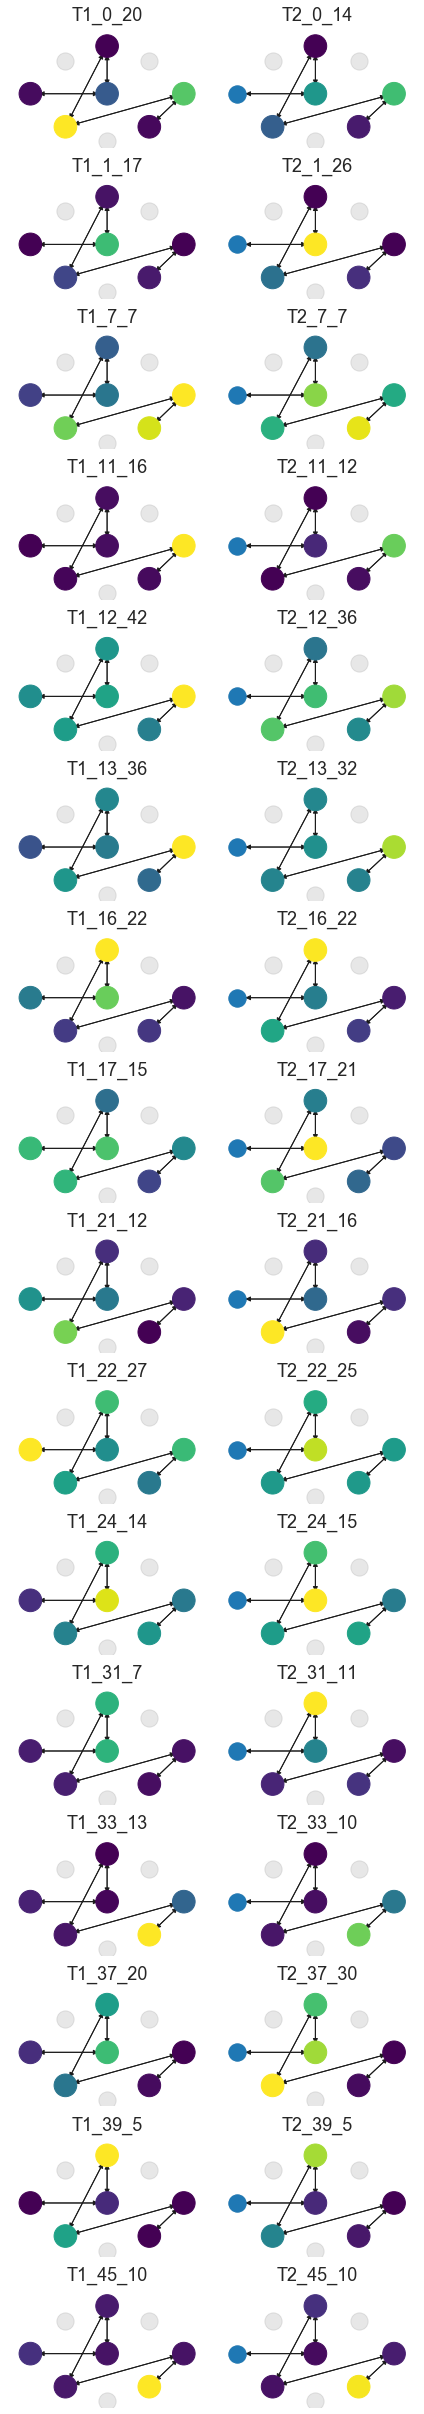

In [1188]:
ctr = 1
ixxx = -1
plt.figure(figsize=(6,42))

THR=2
for a_,b_ in zip(astr,bstr):
    ixxx += 1
    if np.nanmax(np.concatenate([a_,b_]))>5:#np.nanmax(astr#np.logical_and(np.nanmax(a_)>THR,np.nanmax(b_)>THR):#np.nanmax(np.concatenate([a_,b_]))>10:
        
        plt.subplot(20,2,ctr*2-1)
        plt.title("T1_"+str(ixxx)+ '_' + str(int(np.nanmax(a_))))
        
        mx = np.nanmax(np.concatenate([a_,b_]))
        print(mx,ctr)
        
        G0 = nx.DiGraph()

        G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos)
        nx.draw_networkx_nodes(G0,pos=np.array([1,-1])*poke_pos,alpha=.1,node_color='k',linewidths=1)
        G = nx.DiGraph()
        G.add_edges_from([i for i in edges[0] if None not in i])
        nx.draw(G,
            pos=np.array([1,-1])*poke_pos,)
        nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,
                node_color=a_,vmin=0,vmax=mx
                ,cmap='viridis',node_size=512)

        
        plt.subplot(20,2,ctr*2)
        plt.title("T2_"+str(ixxx)+ '_' + str(int(np.nanmax(b_))))
        G0 = nx.DiGraph()
        G0.add_nodes_from(np.arange(9),pos=np.array([1,-1])*poke_pos)
        nx.draw_networkx_nodes(G0,pos=np.array([1,-1])*poke_pos,alpha=.1,node_color='k',linewidths=1)
        
        G = nx.DiGraph()
        G.add_edges_from([i for i in edges[0] if None not in i])
        nx.draw(G,
            pos=np.array([1,-1])*poke_pos,)
        nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,
                node_color=b_,vmin=0,vmax=mx
                ,cmap='viridis',node_size=512)

        ctr += 1
plt.tight_layout()

In [755]:
a_

array([ 1.72413793,         nan,         nan,  1.21212121,  0.33898305,
        0.95238095,  0.47619048, 10.37037037,         nan])

In [756]:
b_

array([0.        , 0.        , 0.70175439, 0.6779661 ,        nan,
              nan, 0.86956522,        nan, 0.        ])

ValueError: num must be 1 <= num <= 20, not 21

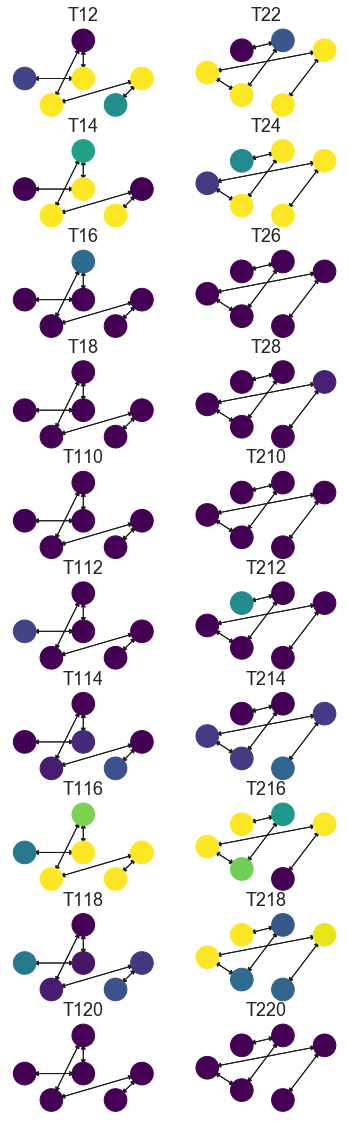

In [757]:
ctr = 1
plt.figure(figsize=(6,20))

for a_,b_ in zip(astr,bstr):
    if True:#np.any(np.concatenate([a_,b_])>3):
        
        plt.subplot(10,2,ctr*2-1)
        plt.title("T1"+str(ctr*2))
        
        G0 = nx.DiGraph()

        G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos)
        #nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,node_color=bstr[i],)
        G = nx.DiGraph()
        G.add_edges_from([i for i in edges[0] if None not in i])
        nx.draw(G,
            pos=np.array([1,-1])*poke_pos,)
        nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,
                node_color=a_,vmin=0,vmax=np.nanmax([3,np.max(a_)])
                ,cmap='viridis',node_size=512)

        
        plt.subplot(10,2,ctr*2)
        plt.title("T2"+str(ctr*2))
        G0 = nx.DiGraph()
        G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos)
        #nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,node_color=bstr[i],)
        G = nx.DiGraph()
        G.add_edges_from([i for i in edges[1] if None not in i])
        nx.draw(G,
            pos=np.array([1,-1])*poke_pos,)
        nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,
                node_color=b_,vmin=0,vmax=np.nanmax([2,np.max(b_)])
                ,cmap='viridis',node_size=512)
        
        ctr += 1
plt.tight_layout()

In [62]:
np.max(b_)

nan

In [61]:
b_

array([0.05405405, 0.01587302, 0.14035088, 0.01694915,        nan,
              nan, 0.00869565,        nan, 0.        ])

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


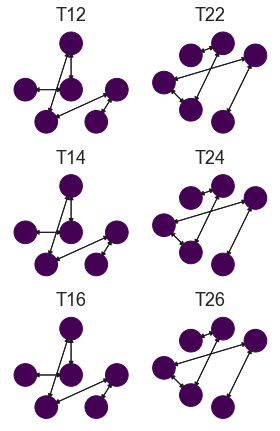

In [47]:
ctr = 1
plt.figure(figsize=(4,16))

for a_,b_ in zip(astr,bstr):
    if np.any(np.concatenate([a_,b_])>5):
        
        plt.subplot(8,2,ctr*2-1)
        plt.title("T1"+str(ctr*2))
        
        G0 = nx.DiGraph()

        G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos)
        #nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,node_color=bstr[i],)
        G = nx.DiGraph()
        G.add_edges_from([i for i in edges[0] if None not in i])
        nx.draw(G,
            pos=np.array([1,-1])*poke_pos,)
        nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,
                node_color=a_,vmin=0,vmax=np.max([3,np.max(a_)])
                ,cmap='viridis',node_size=512)

        
        plt.subplot(8,2,ctr*2)
        plt.title("T2"+str(ctr*2))
        G0 = nx.DiGraph()
        G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos)
        #nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,node_color=bstr[i],)
        G = nx.DiGraph()
        G.add_edges_from([i for i in edges[1] if None not in i])
        nx.draw(G,
            pos=np.array([1,-1])*poke_pos,)
        nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,
                node_color=b_,vmin=0,vmax=np.max([3,np.max(b_)])
                ,cmap='viridis',node_size=512)
        
        ctr += 1
plt.tight_layout()

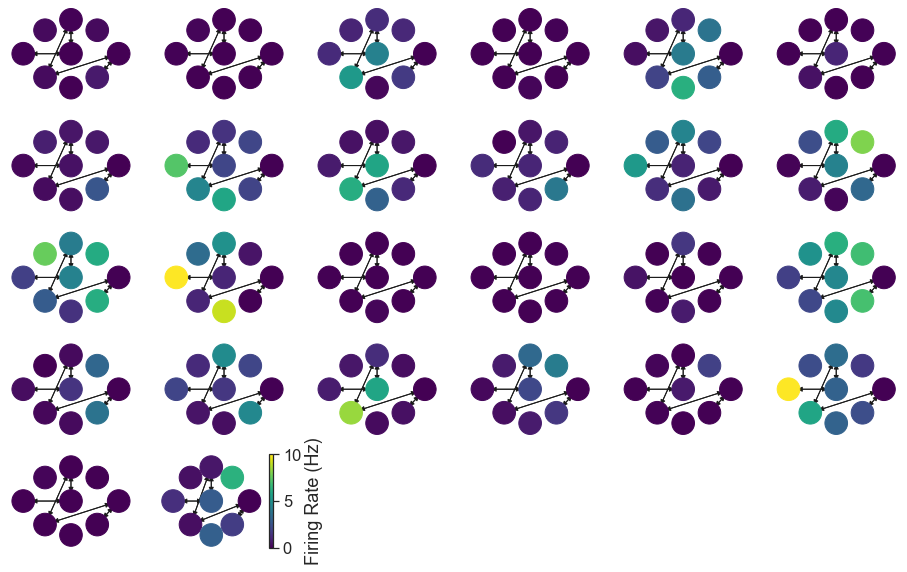

<Figure size 432x288 with 0 Axes>

In [253]:
plt.figure(figsize=(16,12))
ctr = 1
for i in range(36):
    if np.any(bstr[i]>0):
        plt.subplot(6,6,ctr)
        ctr += 1
        G0 = nx.DiGraph()

        G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos)
        #nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,node_color=bstr[i],)
        G = nx.DiGraph()
        G.add_edges_from([i for i in edges[0] if None not in i])
        nx.draw(G,
            pos=np.array([1,-1])*poke_pos,)
        nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,
                node_color=bstr[i],vmin=0,vmax=np.max([3,np.max(astr[i])])
                ,cmap='viridis',node_size=512)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin = 0, vmax=10))
sm._A = []
cbar = plt.colorbar(sm)
cbar.set_label("Firing Rate (Hz)")
plt.show()
plt.tight_layout()

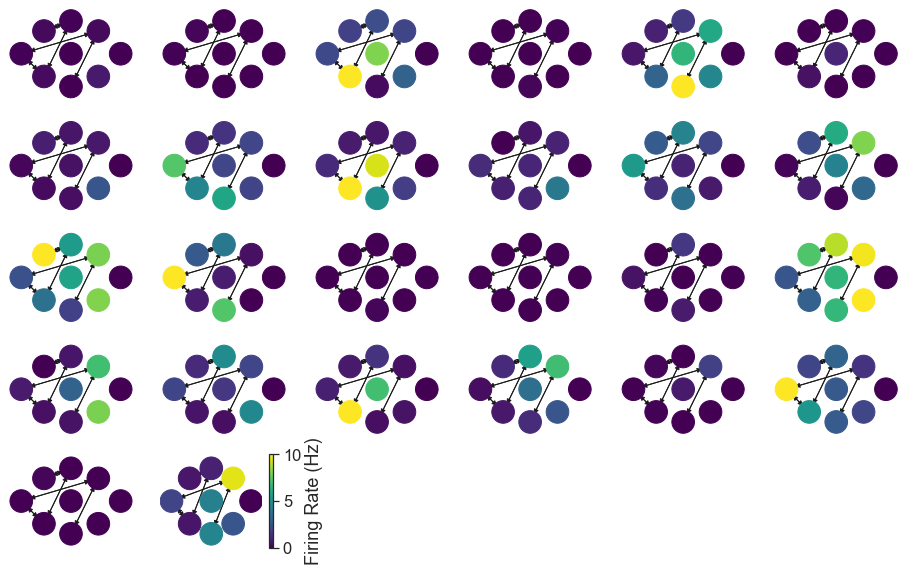

<Figure size 432x288 with 0 Axes>

In [254]:
plt.figure(figsize=(16,12))
ctr = 1
for i in range(36):
    if np.any(bstr[i]>0):
        plt.subplot(6,6,ctr)
        ctr += 1
        G0 = nx.DiGraph()

        G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos)
        #nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,node_color=bstr[i],)
        G = nx.DiGraph()
        G.add_edges_from([i for i in edges[1] if None not in i])
        nx.draw(G,
            pos=np.array([1,-1])*poke_pos,)
        nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,
                node_color=bstr[i],vmin=0,vmax=np.max([3,np.max(bstr[i])])
                ,cmap='viridis',node_size=512)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin = 0, vmax=10))
sm._A = []
cbar = plt.colorbar(sm)
cbar.set_label("Firing Rate (Hz)")
plt.show()
plt.tight_layout()

In [64]:
len(bstr)

46

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


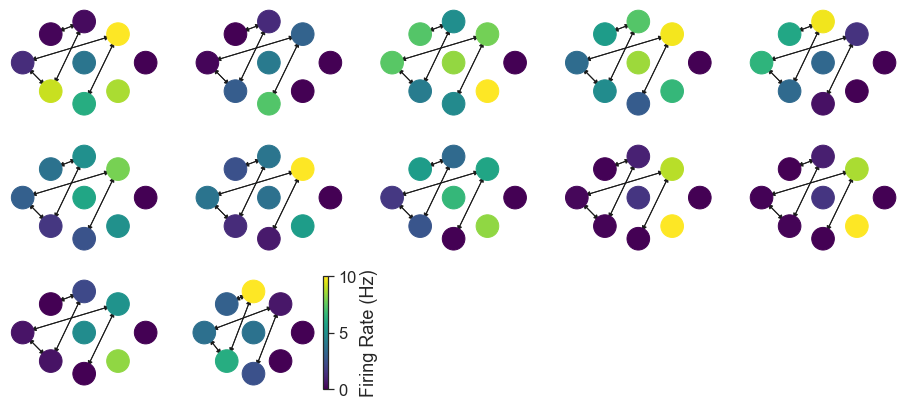

<Figure size 432x288 with 0 Axes>

In [65]:
plt.figure(figsize=(16,12))
ctr = 1
for i in range(46):
    if np.any(bstr[i]>2):
        plt.subplot(5,5,ctr)
        ctr += 1
        G0 = nx.DiGraph()

        G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos)
        #nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,node_color=bstr[i],)
        G = nx.DiGraph()
        G.add_edges_from([i for i in edges if None not in i])
        nx.draw(G,
            pos=np.array([1,-1])*poke_pos,)
        nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=1,
                node_color=bstr[i],vmin=0,vmax=np.max([3,np.max(bstr[i])])
                ,cmap='viridis',node_size=512)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin = 0, vmax=10))
sm._A = []
cbar = plt.colorbar(sm)
cbar.set_label("Firing Rate (Hz)")
plt.show()
plt.tight_layout()

In [110]:
shuffs = []
for _ in range(1000):
    shuffs.append([np.corrcoef(i,j)[0,1] for i,j in zip(astr,np.random.permutation(bstr)) if not np.isnan(np.corrcoef(i,j)[0,1])])

In [111]:
shuffs = np.array(shuffs)

In [112]:
shuffs.shape

(1000,)

TypeError: unsupported operand type(s) for /: 'list' and 'int'

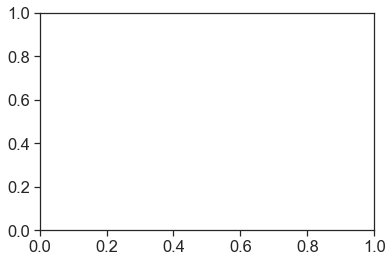

In [113]:
seaborn.distplot(shuffs)
plt.axvline(x=0.15)

In [147]:
from scipy.stats import f_oneway

In [148]:
astr = spk_by_ev/np.max(spk_by_ev,axis=1)[:,None]

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


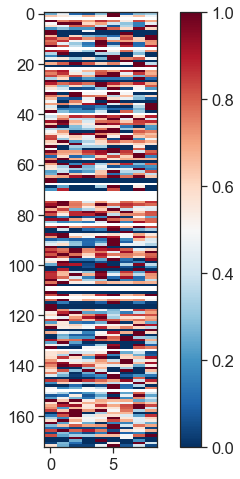

In [149]:
plt.figure(figsize=(8,8))
plt.imshow(spk_by_ev/np.max(spk_by_ev,axis=1)[:,None],aspect=.2,interpolation='None',cmap='RdBu_r')

plt.colorbar()

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


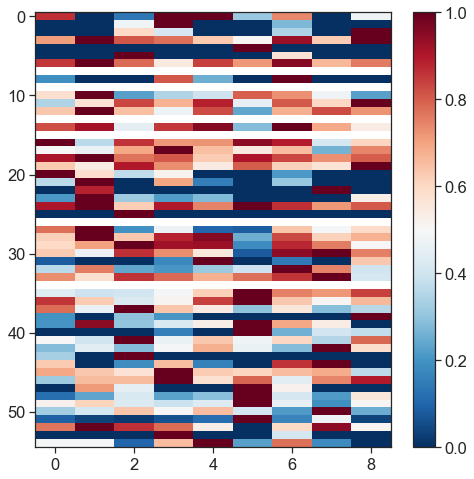

In [1014]:
plt.figure(figsize=(8,8))
plt.imshow(spk_by_ev/np.max(spk_by_ev,axis=1)[:,None],aspect=.2,interpolation='None',cmap='RdBu_r')

plt.colorbar()

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


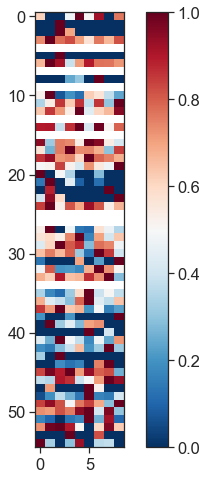

In [414]:
plt.figure(figsize=(8,8))
plt.imshow(spk_by_ev/np.max(spk_by_ev,axis=1)[:,None],aspect=.8,interpolation='None',cmap='RdBu_r')

plt.colorbar()

# Run ANOVA for significance 

In [ ]:
full_list = []
for uCtr,u in enumerate(spks):
    tmp = []
spk_by_ev = np.zeros([len(unit_ids),len(event_types)])
    for eCtr, etype in enumerate(event_types):


        ets = event_times[np.where(events==etype)[0]]*30000

        if len(ets)>0:
            tmp0 = 0
            for eT in ets:

                for uCtr,u in enumerate(spks):
                    spk_by_ev[uCtr,eCtr] += np.sum(np.logical_and(u<=(eT+6000),u>(eT)))
                tmp0 += 1
            spk_by_ev[:,eCtr] /= tmp0
            #print(len(ets))


    all_dat.append(spk_by_ev)
astr = all_dat[0]
bstr = all_dat[1]